In [1]:
from pycocotools.coco import COCO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
from random import randint

coco_folder = './'
dp_coco = COCO( coco_folder + './densepose_coco_2014_minival.json')

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


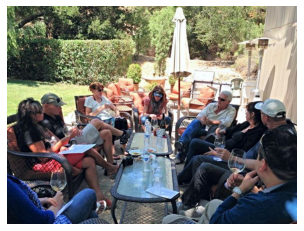

In [10]:
# Get img id's for the minival dataset.
im_ids = dp_coco.getImgIds()
# Select a random image id.
Selected_im = im_ids[randint(0, len(im_ids))] # Choose im no 57 to replicate 
# Load the image
im = dp_coco.loadImgs(Selected_im)[0]  
# Load Anns for the selected image.
ann_ids = dp_coco.getAnnIds( imgIds=im['id'] )
anns = dp_coco.loadAnns(ann_ids)
# Now read and b
im_name = os.path.join( coco_folder + 'val2014', im['file_name'] )
I=cv2.imread(im_name)
plt.imshow(I[:,:,::-1]); plt.axis('off'); plt.show()

In [11]:
def GetDensePoseMask(Polys):
    MaskGen = np.zeros([256,256])
    for i in range(1,15):
        if(Polys[i-1]):
            current_mask = mask_util.decode(Polys[i-1])
            MaskGen[current_mask>0] = i
    return MaskGen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


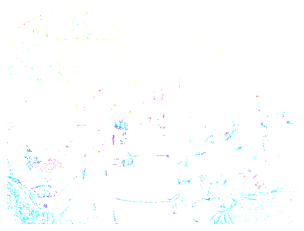

In [12]:
I_vis=I.copy()/2 # Dim the image.

for ann in anns:  
    bbr =  np.array(ann['bbox']).astype(int) # the box.
    if( 'dp_masks' in ann.keys()): # If we have densepose annotation for this ann,
        Mask = GetDensePoseMask(ann['dp_masks'])
        ################
        x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
        x2 = min( [ x2,I.shape[1] ] );  y2 = min( [ y2,I.shape[0] ] )
        ################ 
        MaskIm = cv2.resize( Mask, (int(x2-x1),int(y2-y1)) ,interpolation=cv2.INTER_NEAREST)
        MaskBool = np.tile((MaskIm==0)[:,:,np.newaxis],[1,1,3])
        #  Replace the visualized mask image with I_vis.
        Mask_vis = cv2.applyColorMap( (MaskIm*15).astype(np.uint8) , cv2.COLORMAP_PARULA)[:,:,:]
        Mask_vis[MaskBool]=I_vis[y1:y2,x1:x2,:][MaskBool]
        I_vis[y1:y2,x1:x2,:] = I_vis[y1:y2,x1:x2,:]*0.3 + Mask_vis*0.7

plt.imshow(I_vis[:,:,::-1]); plt.axis('off'); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


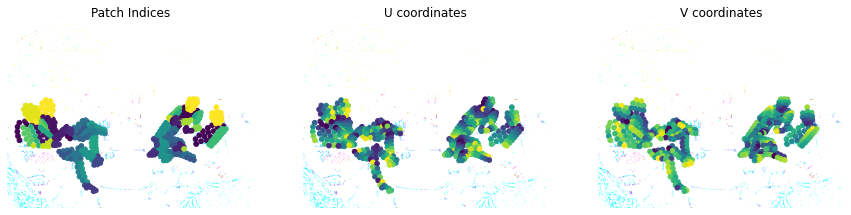

In [13]:
# Show images for each subplot.
fig = plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(I[:,:,::-1]/2);plt.axis('off');plt.title('Patch Indices')
plt.subplot(1,3,2)
plt.imshow(I[:,:,::-1]/2);plt.axis('off');plt.title('U coordinates')
plt.subplot(1,3,3)
plt.imshow(I[:,:,::-1]/2);plt.axis('off');plt.title('V coordinates')

## For each ann, scatter plot the collected points.
for ann in anns:
    bbr =  np.round(ann['bbox']) 
    if( 'dp_masks' in ann.keys()):
        Point_x = np.array(ann['dp_x'])/ 255. * bbr[2] # Strech the points to current box.
        Point_y = np.array(ann['dp_y'])/ 255. * bbr[3] # Strech the points to current box.
        #
        Point_I = np.array(ann['dp_I'])
        Point_U = np.array(ann['dp_U'])
        Point_V = np.array(ann['dp_V'])
        #
        x1,y1,x2,y2 = bbr[0],bbr[1],bbr[0]+bbr[2],bbr[1]+bbr[3]
        x2 = min( [ x2,I.shape[1] ] ); y2 = min( [ y2,I.shape[0] ] )
        ###############
        Point_x = Point_x + x1 ; Point_y = Point_y + y1
        plt.subplot(1,3,1)
        plt.scatter(Point_x,Point_y,22,Point_I)
        plt.subplot(1,3,2)
        plt.scatter(Point_x,Point_y,22,Point_U)
        plt.subplot(1,3,3)
        plt.scatter(Point_x,Point_y,22,Point_V)
        
plt.show()